In [1]:
import numpy as np
import math
import random

patterns = []
classes = []

filename = 'Iris_data.txt'
file = open(filename,'r')

for line in file.readlines():
    row = line.strip().split(',')
    patterns.append(row[0:4])
    classes.append(row[4])
print "Iris Data Loaded"
file.close

patterns = np.asarray(patterns,dtype=np.float32)

sample_no = np.random.randint(0,len(patterns))

print "Sample pattern: "+str(patterns[int(sample_no)])
print "Class of the above pattern: "+str(classes[int(sample_no)])
    

Iris Data Loaded
Sample pattern: [ 5.5         2.5999999   4.4000001   1.20000005]
Class of the above pattern: Iris-versicolor


In [2]:
#A heuristic formula for calculating no. of map units
#source: https://stackoverflow.com/questions/19163214/kohonen-self-organizing-maps-determining-the-number-of-neurons-and-grid-size

def mapunits(input_len,size='small'):
    
    heuristic_map_units = 5*len(patterns)**0.54321
     
    if size == 'big':
        heuristic_map_units = 4*(heuristic_map_units)
    else:
        heuristic_map_units = 0.25*(heuristic_map_units)
        
    return heuristic_map_units
        
        
map_units = mapunits(len(patterns),size='big')
print "Heuristically computed appropriate no. of map units: "+str(int(map_units))

#For reference purpose only - however this function can be used to automatically calculate the SOM dimensions
#from data length. I will still be specifying the SOM dimensions manually, anyway.

Heuristically computed appropriate no. of map units: 304


In [3]:
input_dimensions = 4

map_width = 9
map_height = 5
MAP = np.random.uniform(size=(map_height,map_width,input_dimensions))
prev_MAP = np.zeros((map_height,map_width,input_dimensions))

radius0 = max(map_width,map_height)/2
learning_rate0 = 0.1

coordinate_map = np.zeros([map_height,map_width,2],dtype=np.int32)

for i in xrange(0,map_height):
    for j in xrange(0,map_width):
        coordinate_map[i][j] = [i,j]

In [4]:
def Eucli_dists(MAP,x):
    x = x.reshape((1,1,-1))
    Eucli_MAP = MAP - x
    Eucli_MAP = Eucli_MAP**2
    Eucli_MAP = np.sqrt(np.sum(Eucli_MAP,2))
    return Eucli_MAP

epochs = 500
radius=radius0
learning_rate = learning_rate0
max_iterations = epochs*len(patterns)
too_many_iterations = 10*max_iterations
BMU = np.zeros([2],dtype=np.int32)

timestep=1
e=0.001 
flag=0

epoch=0
while epoch <= epochs:
    
    shuffle = random.sample(np.arange(0,len(patterns),1,'int'),len(patterns))
  
    for i in xrange(0,len(patterns)):
        
        # difference between prev_MAP and MAP
        J = np.sqrt(np.sum(np.sum((prev_MAP-MAP)**2,2)))
        # J = || euclidean distance between previous MAP and current MAP  ||

        if  J<= e: #if converged (convergence criteria)
            flag=1
            break
            
        else:
            
            if timestep == max_iterations and timestep != too_many_iterations:
                epochs += 1
                max_iterations = epochs*len(patterns)
            
            pattern = patterns[shuffle[i]]
            Eucli_MAP = Eucli_dists(MAP,pattern)
        
            BMU[0] = np.argmin(np.amin(Eucli_MAP,1),0)
            BMU[1] = np.argmin(Eucli_MAP,1)[int(BMU[0])]
    
            Eucli_from_BMU = Eucli_dists(coordinate_map,BMU)  
        
            prev_MAP = np.copy(MAP)
            
            for i in xrange(0,map_height):
                for j in xrange(0,map_width):
                    distance = Eucli_from_BMU[i][j]
                    if distance <= radius:
                        theta = math.exp(-(distance**2)/(2*(radius**2)))
                        MAP[i][j] = MAP[i][j] + theta*learning_rate*(pattern-MAP[i][j])
            
            learning_rate = learning_rate0*math.exp(-(timestep)/max_iterations)
            time_constant = max_iterations/math.log(radius) 
            radius = radius0*math.exp(-(timestep)/time_constant)
            
            timestep+=1
            
    if flag==1:
        break
    epoch+=1
    

In [5]:
print timestep
print J

750151
0.0241663659322



Red = Iris-Setosa
Green = Iris-Virginica
Blue = Iris-Versicolor



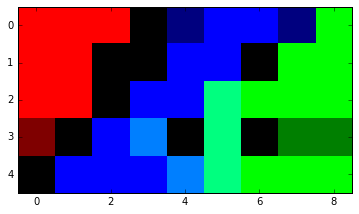

In [6]:
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline

BMU = np.zeros([2],dtype=np.int32)
result_map = np.zeros([map_height,map_width,3],dtype=np.float32)

i=0
for pattern in patterns:
    
    Eucli_MAP = Eucli_dists(MAP,pattern)
    
    BMU[0] = np.argmin(np.amin(Eucli_MAP,1),0)
    BMU[1] = np.argmin(Eucli_MAP,1)[int(BMU[0])]
    
    x = BMU[0]
    y = BMU[1]
    
    if classes[i] == 'Iris-setosa':
        if result_map[x][y][0] <= 0.5:
            result_map[x][y] += np.asarray([0.5,0,0])
    elif classes[i] == 'Iris-virginica':
        if result_map[x][y][1] <= 0.5:
            result_map[x][y] += np.asarray([0,0.5,0])
    elif classes[i] == 'Iris-versicolor':
        if result_map[x][y][2] <= 0.5:
            result_map[x][y] += np.asarray([0,0,0.5])
    i+=1
result_map = np.flip(result_map,0)
    
#print result_map

print "\nRed = Iris-Setosa"
print "Green = Iris-Virginica"
print "Blue = Iris-Versicolor\n"

plt.imshow(toimage(result_map),interpolation='nearest')